In [1]:
import tensorflow as tf
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import visualize
from models import generator_AC_GAN_64_64, discriminator_AC_GAN_64_64
from data_utils import read_comic_test_label, read_and_decode

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

c:\users\fanhangming\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
batch_size = 64
learning_rate = 2e-4
epochs = 10
noise_dim = 100
num_train = 36740

In [3]:
def sample_noise(batch_size, dim):
    return np.random.normal(loc=0., scale=0.5, size=(batch_size, dim))
    #return np.random.normal(size=[batch_size, dim])

# TODO: return np.uint8 and modify code in visiualize.py to show better organization
def post_process(img):
    return (img+1) * 127.5

def make_t_fake():
    temp_fake = np.zeros((batch_size, 22))
    for i in range(batch_size):
        temp_fake[i, np.random.randint(0, 12)] = 1 # hair
        temp_fake[i, np.random.randint(12, 22)] = 1 # eye
    return temp_fake

def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step, saver,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10, n_critic=5):
    D_losses = []
    G_losses = []
    
    max_iter = num_train * num_epoch // batch_size
    for it in range(max_iter):
        # show test data
        if (it+1) % show_every == 0:
            noise_z = sample_noise(25, noise_dim)
            samples = sess.run(G_sample, feed_dict={z:noise_z, t: test_labels})
            visualize.show_images_and_loss_64_64(samples, D_losses, G_losses, post_process=post_process)
            D_losses, G_losses = [], []
            
        if (it+1) % 300 == 0:
            saver.save(sess, 'checkpoints/condition_comic/c_comic', it)
            
        for i in range(n_critic):
            noise_z = sample_noise(batch_size, noise_dim)
            x_batch, t_batch = sess.run([image_batch, label_batch])
            _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: x_batch, z: noise_z, t: t_batch, t_fake:make_t_fake()})
            D_losses.append(D_loss_curr)
        
        __, G_loss_curr = sess.run([G_train_step, G_loss], feed_dict={x: x_batch, z: noise_z, t: t_batch, t_fake:make_t_fake()})
        G_losses.append(G_loss_curr)
        
        # show loss
        if it % print_every == 0:
            print('Iter: {0}/{1}, D: {2:.4}, G: {3:.4}'.format(it, max_iter, D_loss_curr, G_loss_curr))
    print('Final images')
    saver.save(sess, 'checkpoints/condition_comic/c_comic', max_iter)
    noise_z = sample_noise(25, noise_dim)
    samples = sess.run(G_sample, feed_dict={z:noise_z, t: test_labels})
    
    fig = visualize.show_images_and_loss_64_64(samples, final="./images/AC-GAN64_64", post_proces=post_process)
    plt.show()

In [4]:
tf.reset_default_graph()

test_labels = read_comic_test_label('./dataset/extra_data/testing_tags.txt')
images, labels = read_and_decode('./dataset/tfrecords/anime_label.tfrecords')
image_batch, label_batch = tf.train.shuffle_batch([images, labels],
                                                 batch_size=batch_size, capacity=2000, min_after_dequeue=1000)

In [5]:
x = tf.placeholder(tf.float32, [batch_size, 64, 64, 3])
z = tf.placeholder(tf.float32, [None, noise_dim])
t = tf.placeholder(tf.float32, [None, 22])
t_fake = tf.placeholder(tf.float32, [None, 22])

generator = generator_AC_GAN_64_64
discriminator = discriminator_AC_GAN_64_64

G_sample = generator(z, t, reuse=False)
logits_real = discriminator(x, t, reuse=False)
logits_fake_1 = discriminator(G_sample, t, reuse=True)
logits_fake_2 = discriminator(x, t_fake, reuse=True)

D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

In [6]:
def wgangp_loss(logits_real, logits_fake_1, logits_fake_2, batch_size, x, G_sample):
    # TODO: compute D_loss and G_loss
    D_loss = (tf.reduce_mean(logits_fake_1) + tf.reduce_mean(logits_fake_2))/2 - tf.reduce_mean(logits_real)
    G_loss = -tf.reduce_mean(logits_fake_1)

    # lambda from the paper
    lam = 10
    
    # random sample of batch_size (tf.random_uniform)
    shape = tf.concat((tf.shape(x)[0:1], tf.tile([1], [x.shape.ndims - 1])), axis=0)
    eps = tf.random_uniform(shape=shape, minval=0., maxval=1.)
    x_hat = x + eps * (G_sample - x)
    
    # Gradients of Gradients is kind of tricky!
    with tf.variable_scope('',reuse=True) as scope:
        pred = discriminator(x_hat, t)
        grad_D_x_hat = tf.gradients(pred, x)[0]
        
    #grad_norm = tf.sqrt(tf.reduce_sum(tf.square(grad_D_x_hat), reduction_indices=1))
    grad_norm = tf.sqrt(tf.reduce_sum(tf.square(grad_D_x_hat), reduction_indices=tf.range(1, x.shape.ndims)))
    grad_pen = lam * tf.reduce_mean((grad_norm - 1.) ** 2)
    
    D_loss = D_loss + grad_pen
    
    return D_loss, G_loss

D_loss, G_loss  =wgangp_loss(logits_real, logits_fake_1, logits_fake_2, batch_size, x, G_sample)
D_train_step = tf.train.AdamOptimizer(learning_rate=2e-4, beta1=0.5).minimize(D_loss, var_list=D_vars)
G_train_step = tf.train.AdamOptimizer(learning_rate=2e-4, beta1=0.5).minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

INFO:tensorflow:Restoring parameters from checkpoints/condition_comic\c_comic-599
Iter: 0/17221, D: 6.474e+09, G: 1.631e+10
Iter: 50/17221, D: 2.424e+09, G: 3.863e+09
Iter: 100/17221, D: -4.477e+09, G: -8.483e+09
Iter: 150/17221, D: -2.895e+09, G: -2.579e+09
Iter: 200/17221, D: -4.169e+09, G: -7.881e+09
Iter: 250/17221, D: 3.738e+09, G: 9.323e+09


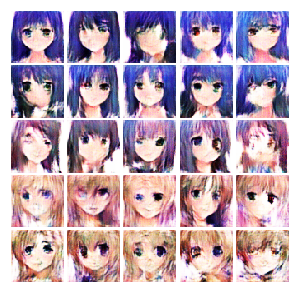

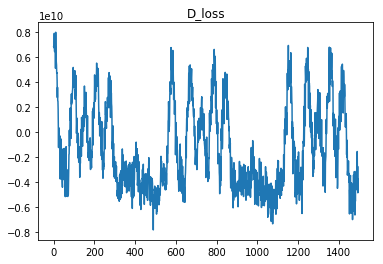

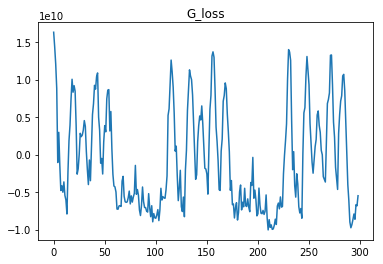

Iter: 300/17221, D: -5.263e+09, G: -7.992e+09
Iter: 350/17221, D: -2.546e+09, G: -4.93e+09
Iter: 400/17221, D: 3.089e+09, G: 5.79e+09
Iter: 450/17221, D: -4.953e+09, G: -7.225e+09
Iter: 500/17221, D: 4.245e+09, G: 1.397e+10
Iter: 550/17221, D: -6.51e+09, G: -9.776e+09


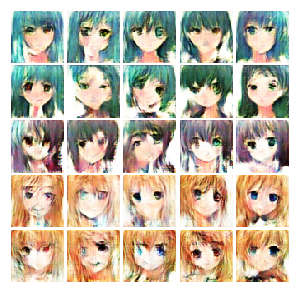

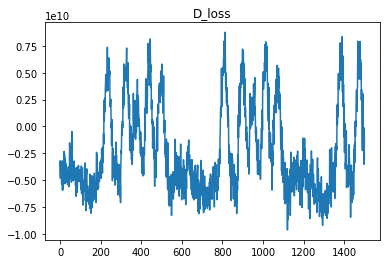

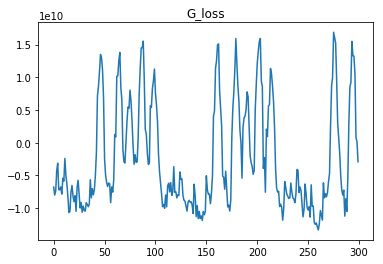

Iter: 600/17221, D: -1.873e+09, G: -1.274e+08
Iter: 650/17221, D: -5.17e+09, G: -8.175e+09
Iter: 700/17221, D: -7.24e+09, G: -9.754e+09
Iter: 750/17221, D: -8.629e+09, G: -1.135e+10
Iter: 800/17221, D: -3.994e+09, G: -4.452e+08
Iter: 850/17221, D: -3.34e+09, G: -5.798e+09


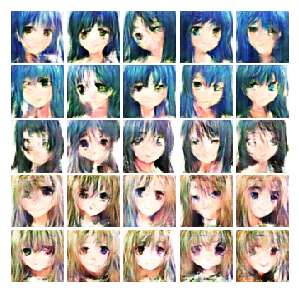

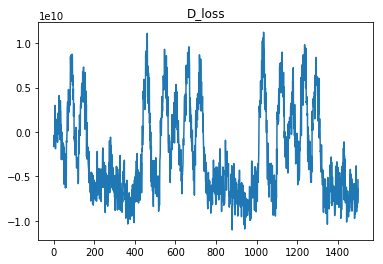

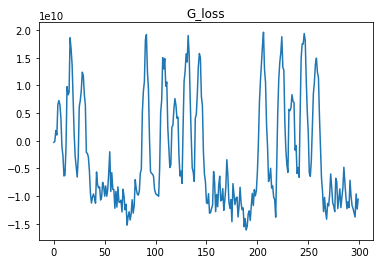

Iter: 900/17221, D: -7.988e+09, G: -1.378e+10
Iter: 950/17221, D: 9.777e+08, G: 4.588e+09
Iter: 1000/17221, D: -5.047e+09, G: -7.903e+09
Iter: 1050/17221, D: 7.054e+09, G: 1.739e+10
Iter: 1100/17221, D: -7.481e+09, G: -8.344e+09
Iter: 1150/17221, D: 7.586e+09, G: 2.465e+10
INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.CancelledError'>, Run call was cancelled


KeyboardInterrupt: 

In [7]:
saver = tf.train.Saver()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    
    ckpt =  tf.train.get_checkpoint_state(os.path.dirname('checkpoints/condition_comic/checkpoint'))
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)

    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step, saver,
              show_every=300, print_every=50, batch_size=batch_size, num_epoch=30, n_critic=5)
    coord.request_stop()
    coord.join(threads)